Found 31 significant stay points.
Saved detailed significant locations to significant_places.csv


C:\Users\prath\PycharmProjects\cs4501Project1\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\prath\PycharmProjects\cs4501Project1\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


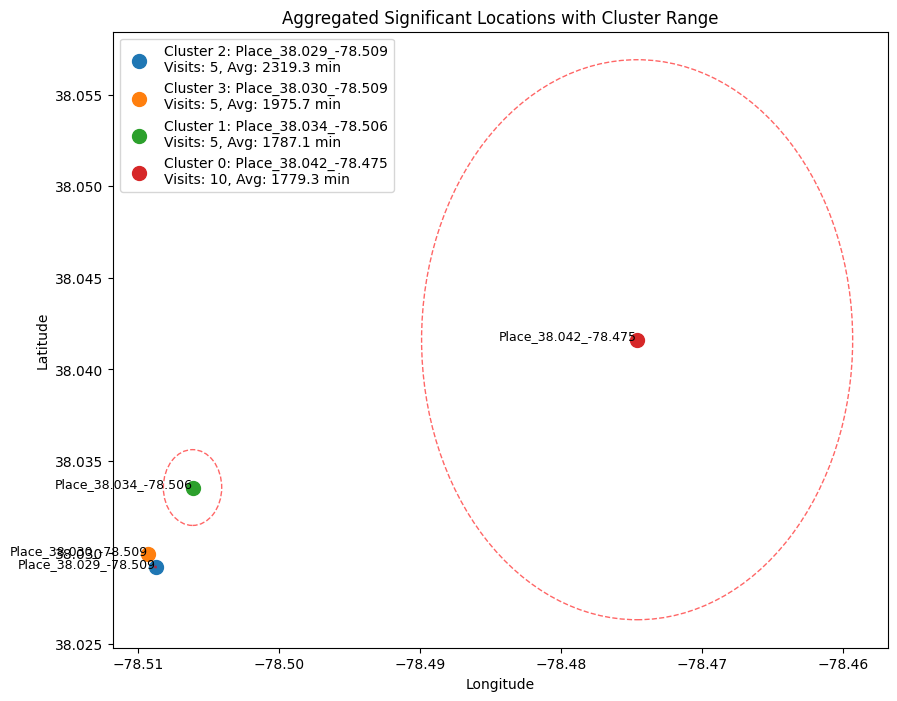

Static map saved as static_map.png
Interactive map saved as interactive_map.html


In [20]:
import json
import math
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import hdbscan
import requests

def haversine_distance(lat1, lon1, lat2, lon2):
    """ Compute the haversine distance between two (lat, lon) pairs in kilometers. """
    R = 6371.0  # Earth radius in kilometers
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def parse_location_history(file_path, time_threshold=30):
    """ Parse the JSON file and extract 'visit' entries with a duration above the threshold. """
    with open(file_path, 'r') as f:
        data = json.load(f)

    records = []
    for entry in data:
        if "visit" in entry:
            visit = entry["visit"]
            if "topCandidate" in visit and "placeLocation" in visit["topCandidate"]:
                loc_str = visit["topCandidate"]["placeLocation"]
                if loc_str.startswith("geo:"):
                    try:
                        lat_str, lon_str = loc_str[4:].split(',')
                        lat = float(lat_str)
                        lon = float(lon_str)
                    except Exception:
                        continue
                else:
                    continue

                try:
                    start_time = datetime.fromisoformat(entry["startTime"].replace("Z", "+00:00"))
                    end_time = datetime.fromisoformat(entry["endTime"].replace("Z", "+00:00"))
                except Exception:
                    continue

                duration = (end_time - start_time).total_seconds() / 60.0  # minutes
                if duration >= time_threshold:
                    records.append({
                        'latitude': lat,
                        'longitude': lon,
                        'start_time': start_time,
                        'end_time': end_time,
                        'duration': duration
                    })
    return pd.DataFrame(records)

def cluster_locations(df, min_cluster_size=3, cluster_epsilon=0.0001):
    """ Cluster the locations using HDBSCAN with the haversine metric. """
    coords = df[['latitude', 'longitude']].to_numpy()
    coords_rad = np.radians(coords)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                metric='haversine',
                                cluster_selection_epsilon=cluster_epsilon)
    cluster_labels = clusterer.fit_predict(coords_rad)
    df['cluster'] = cluster_labels
    return df, clusterer

def merge_cluster_summary(df):
    """ Compute cluster-level summary statistics for all clusters. """
    summary = df.groupby('cluster').agg(
        visit_count=('duration', 'size'),
        average_duration=('duration', 'mean'),
        center_latitude=('latitude', 'median'),
        center_longitude=('longitude', 'median')
    ).reset_index()

    ranges = []
    for c in summary['cluster']:
        if c == -1:
            r = 0.0
        else:
            group = df[df['cluster'] == c]
            center_lat = summary.loc[summary['cluster'] == c, 'center_latitude'].values[0]
            center_lon = summary.loc[summary['cluster'] == c, 'center_longitude'].values[0]
            dists = group.apply(lambda row: haversine_distance(center_lat, center_lon, row['latitude'], row['longitude']), axis=1)
            r = dists.max()
        ranges.append(r)
    summary['cluster_range_km'] = ranges
    merged = df.merge(summary, on='cluster', how='left')
    return merged

def query_place_api(lat, lon, api_key=None):
    """ Query the Google Maps Reverse Geocoding API for a human-readable location. """
    if api_key is None:
        return "Place_{:.3f}_{:.3f}".format(lat, lon)

    endpoint_url = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {
        "latlng": f"{lat},{lon}",
        "key": api_key
    }
    response = requests.get(endpoint_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data.get('results'):
            return data['results'][0].get('formatted_address', "Unknown Location")
    return "Unknown Location"

def add_cluster_labels(merged_df, api_key=None):
    """ Add human-readable labels to the clusters. """
    clusters = merged_df['cluster'].unique()
    label_map = {}
    for cluster in clusters:
        if cluster == -1:
            label_map[cluster] = "Noise"
        else:
            subset = merged_df[merged_df['cluster'] == cluster]
            lat = subset['center_latitude'].iloc[0]
            lon = subset['center_longitude'].iloc[0]
            label_map[cluster] = query_place_api(lat, lon, api_key)
    merged_df['label'] = merged_df['cluster'].map(label_map)
    return merged_df

def save_csv(merged_df, output_file='significant_places.csv'):
    """ Save the detailed data to a CSV file. """
    merged_df.to_csv(output_file, index=False)
    print(f"Saved detailed significant locations to {output_file}")

def plot_static_map(merged_df):
    """ Generate a static scatter plot of aggregated cluster centers with range circles. """
    unique_clusters = merged_df.drop_duplicates(subset=['cluster'])
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    for _, row in unique_clusters.iterrows():
        cluster = row['cluster']
        if cluster == -1:
            continue
        center_lat = row['center_latitude']
        center_lon = row['center_longitude']
        visits = row['visit_count']
        avg_duration = row['average_duration']
        label_text = row['label']
        cluster_range = row['cluster_range_km']

        plt.scatter(center_lon, center_lat, s=100, label=f"Cluster {cluster}: {label_text}\nVisits: {visits}, Avg: {avg_duration:.1f} min")
        plt.text(center_lon, center_lat, label_text, fontsize=9, ha='right')

        radius_deg = cluster_range / 111.0  # Convert km to degrees
        circle = plt.Circle((center_lon, center_lat), radius_deg, color='r', fill=False, linestyle='--', alpha=0.6)
        ax.add_patch(circle)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Aggregated Significant Locations with Cluster Range")
    plt.legend()
    plt.savefig("static_map.png")
    plt.show()
    print("Static map saved as static_map.png")

def plot_interactive_map(merged_df):
    """ Generate an interactive map with folium including range circles and dotted lines. """
    if not merged_df.empty:
        map_center = [merged_df['latitude'].mean(), merged_df['longitude'].mean()]
    else:
        map_center = [0, 0]

    m = folium.Map(location=map_center, zoom_start=12)

    unique_clusters = merged_df.drop_duplicates(subset=['cluster'])
    for _, row in unique_clusters.iterrows():
        cluster = row['cluster']
        if cluster == -1:
            continue
        center_lat = row['center_latitude']
        center_lon = row['center_longitude']
        visits = row['visit_count']
        avg_duration = row['average_duration']
        cluster_range = row['cluster_range_km']
        label_text = row['label']
        popup_text = f"Cluster {cluster}: {label_text}<br>Visits: {visits}<br>Avg Duration: {avg_duration:.1f} min<br>Range: {cluster_range:.2f} km"
        
        # Add Marker
        folium.Marker(
            location=[center_lat, center_lon],
            popup=popup_text,
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(m)

        # Draw a circle representing the cluster range (convert km to meters)
        folium.Circle(
            location=[center_lat, center_lon],
            radius=cluster_range * 1000,  # Convert km to meters
            color='red',
            fill=False,
            dash_array='5, 5'  # This makes the circle dashed
        ).add_to(m)


    # Add heatmap of all individual significant points
    heat_data = merged_df[['latitude', 'longitude']].values.tolist()
    HeatMap(heat_data).add_to(m)

    m.save("interactive_map.html")
    print("Interactive map saved as interactive_map.html")

def main():
    TIME_THRESHOLD = 30  # minutes
    MIN_CLUSTER_SIZE = 3
    CLUSTER_EPSILON = 0.0000001  # Reduces the effective radius of each cluster (in radians)
    API_KEY = None  # Replace with your Google Maps API key if desired

    # Parse the location history JSON file.
    df = parse_location_history("location-history.json", time_threshold=TIME_THRESHOLD)
    if df.empty:
        print("No significant stays found based on the given time threshold.")
        return
    else:
        print(f"Found {len(df)} significant stay points.")

    # Cluster the locations with a reduced radius.
    df, clusterer = cluster_locations(df, min_cluster_size=MIN_CLUSTER_SIZE, cluster_epsilon=CLUSTER_EPSILON)

    # Merge the cluster-level summary statistics back onto each individual record.
    merged_df = merge_cluster_summary(df)

    # Add cluster labels (using the Google Maps API if API_KEY is set, else placeholder).
    merged_df = add_cluster_labels(merged_df, API_KEY)

    # Save all locations (that appear on the interactive map) to CSV.
    save_csv(merged_df, output_file='significant_places.csv')

    # Generate static map visualization (using aggregated cluster centers and range circles).
    plot_static_map(merged_df)

    # Generate interactive map with detailed info and range circles.
    plot_interactive_map(merged_df)

if __name__ == "__main__":
    main()
